# Submission Notebook

## DS 5110 Final Project 

## Air Quality Group 

* Daniel Heffley (dh3by)
* Camille Leonard (cvl7qu)
* Steph Verbout (sv8jy)
* Shahriar Shahrokhabadi (ss3qs)

# Research Question 

1. Predict air quality at county level for counties in the contiguous US using gas pollutant and particulate matter (PM) data 
2. Predict air quality at county level with gas pollutant and particulate matter data and socio-economic factors 
3. Predict median income at the county level with gas pollutant and particulate matter data and population density

# Data 

Our original data sources were the [EPA's Air Quality Data](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw) and [Socio-Economic data from OpenIntro](https://www.openintro.org/data/?data=county_complete).

We compiled daily data for gas and particulate matter from 2017-2019 and then joined the air quality data with the Scoio-Economic data by county. The Socio-Economic data was published in 2010. 


## Import 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os 
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, DoubleType, TimestampType, DecimalType
from pyspark.sql.functions import col, asc, to_date, unix_timestamp, to_timestamp, count, when, isnan
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, Imputer, StringIndexer
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler
import pyspark.sql.functions as f

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# Navigate to source directory and check it worked
os.chdir(r'/project/ds5559/Air_Quality_Group')
os.getcwd()

'/project/ds5559/Air_Quality_Group'

In [4]:
# Create spark session
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("Create Final Dataset") \
        .config("spark.executor.memory", '20g') \
        .config('spark.executor.cores', '4') \
        .config('spark.executor.instances', '8') \
        .config("spark.driver.memory",'1g') \
        .getOrCreate()


In [5]:
# For viewing in the UI to monitor memory usage. Must be used from the desktop instance. 
# spark.sparkContext.uiWebUrl

In [6]:
# Import data, this data does not include "General_AQI" and labeled point 
df = spark.read.csv('df_cleaned.csv',inferSchema = True ,  header = True)

# EDA

In [7]:
# View schema of imported data before exploring data set 
df.printSchema()

root
 |-- Date Local: string (nullable = true)
 |-- State Code: integer (nullable = true)
 |-- County Code: integer (nullable = true)
 |-- State Name: string (nullable = true)
 |-- County Name: string (nullable = true)
 |-- Arithmetic Mean_CO: double (nullable = true)
 |-- Arithmetic Mean_SO2: double (nullable = true)
 |-- Arithmetic Mean_NO2: double (nullable = true)
 |-- Arithmetic Mean_O3: double (nullable = true)
 |-- AQI: double (nullable = true)
 |-- Category: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- Arithmetic Mean_PM10SPEC_imputed: double (nullable = true)
 |-- Arithmetic Mean_LEAD_imputed: double (nullable = true)
 |-- Arithmetic Mean_HAPS_imputed: double (nullable = true)
 |-- Arithmetic Mean_NO_imputed: double (nullable = true)
 |-- Arithmetic Mean_TEMP_imputed: double (nullable = true)
 |-- Arithmetic Mean_PM2_5NON_FRM_imputed: double (nullable = true)
 |-- pop_density_imputed: double (nullable = true)
 |-- Arithmetic Mean_PM2_5FRM_imputed: double 

### Summary Statistics for Each Numeric Column

In [8]:
# Get list of columns that are of integer and double type. describe.() does not work on categorical variables 
dfColumnList = [field.name for field in df.schema.fields if isinstance(field.dataType, IntegerType) or isinstance(field.dataType, DoubleType)]

# Produce summary statistics for data set
df.describe(dfColumnList).toPandas()

summary          State Code         County Code    Arithmetic Mean_CO  \
0   count             2650234             2650234               2650234   
1    mean  6.7163499524947605  50.622795949338816    0.3832787757555835   
2  stddev   5.437855720670629  30.737932443311887   0.21419911892083554   
3     min                   1                   1  -0.36956500000000003   
4     max                  56                 650              2.221739   

   Arithmetic Mean_SO2 Arithmetic Mean_NO2    Arithmetic Mean_O3  \
0              2650234             2650234               2650234   
1  0.32294027110925616  16.431184522173268  0.029362218305616396   
2  0.25626607598300855     9.3935338765969   0.01063197608331613   
3            -1.308333              -3.875              -5.29E-4   
4                8.555              58.055                 0.078   

                  AQI                fips Arithmetic Mean_PM10SPEC_imputed  \
0             2650234             2650234                          2650234   
1   82.53520858912836   838.9293643504686                7.846779723907236   
2  37.750563377918226  2108.8403683657693               13.915232446882992   
3                 5.0                  61                            -0.01   
4               264.0               51650                       334.416667   

   ... Arithmetic Mean_NO_imputed Arithmetic Mean_TEMP_imputed  \
0  ...                    2650234                      2650234   
1  ...          17.55695908818807              65.095843219819   
2  ...          18.81458449692953            8.835771375200752   
3  ...                  -1.370833                    10.166667   
4  ...                     125.46                      95.2125   

  Arithmetic Mean_PM2_5NON_FRM_imputed pop_density_imputed  \
0                              2650234             2650234   
1                   12.524968379441791  1511.6371977424776   
2                   6.7985713045910705  1121.3967244967891   
3                  -1.2619049999999998                 7.3   
4                           189.291667             32903.6   

  Arithmetic Mean_PM2_5FRM_imputed Arithmetic Mean_WIND_imputed  \
0                          2650234                      2650234   
1               11.250108461700806            97.82468230330934   
2                6.605494070988254           103.99895739809311   
3                        -2.708333                     0.591667   
4                            182.2                        342.5   

  Arithmetic Mean_RH_imputed Arithmetic Mean_PRESS_imputed  \
0                    2650234                       2650234   
1           55.8417369260858             996.2194855915303   
2          18.72221126968443             9.228634032939318   
3         4.9583330000000005                    831.958333   
4                      100.0                   1033.291667   

  Arithmetic Mean_PM10MASS_imputed median_income_imputed  
0                          2650234               2650234  
1               29.082093505705533    29569.814192633556  
2               14.694871346621012    1909.7684038591142  
3                              1.0               18245.0  
4                            316.0               49542.0  

[5 rows x 22 columns]

### Correlation Table

In [9]:
# Get list of columns that are integer and double type
columnList = [field.name for field in df.schema.fields if isinstance(field.dataType, IntegerType) or isinstance(field.dataType, DoubleType)]

# Remove the binary columns that were added to the table 
columnList = columnList[:-7] #this may need to be 9 

# Convert to vector column first
vector_col = "corr_features"

# Assemble columns into one column for tranform operation 
assembler = VectorAssembler(inputCols=columnList, outputCol=vector_col)

# Create vector to perform correlation calculations on
df_vector = assembler.transform(df).select(vector_col)

# Get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

# Reformat for next step 
corrmatrix = matrix.toArray().tolist()

In [15]:
# Set table precision to 3 
pd.set_option('precision', 3)

# Create spark dataframe of correlation matrix and columns 
df_corr = spark.createDataFrame(corrmatrix,columnList)

# Convert to pandas df so that it can be visualized
df_corr = df_corr.toPandas()
#df_corr = df_corr.round(decimals=3)

# Set index so labels show up on the y axis
df_corr['index'] = columnList
df_corr = df_corr.set_index('index')

# Stylistic formatting 
df_corr.style.background_gradient(cmap="Blues")

In [11]:
# Take sample of data to visualize 
df_for_plot = df.sample(0.001, seed = 314).toPandas()

In [12]:
# Define histogram function to visualize all the variables 
def hist(hist_col):
    # set a grey background 
    sns.set(style="darkgrid")
    
    # make plot 
    sns.histplot(data=df_for_plot, x=x)
    plt.show()

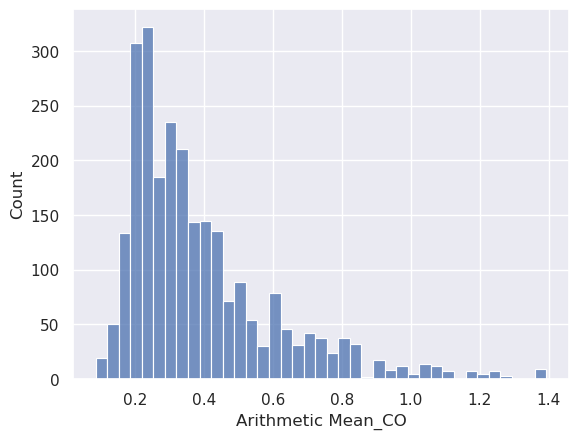

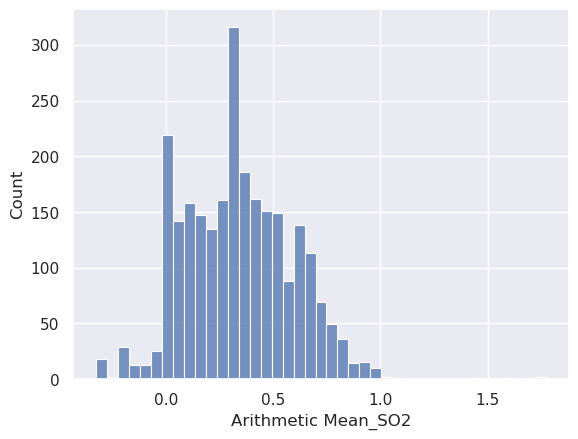

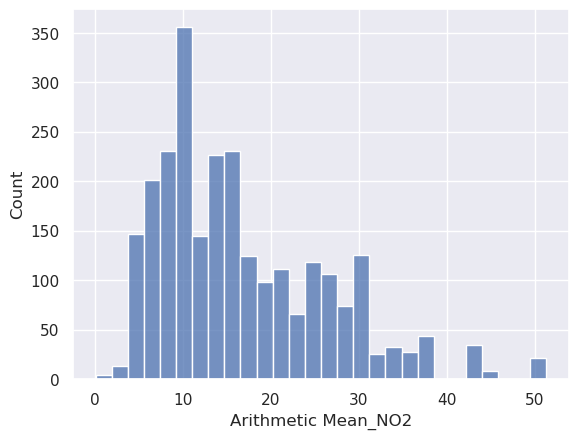

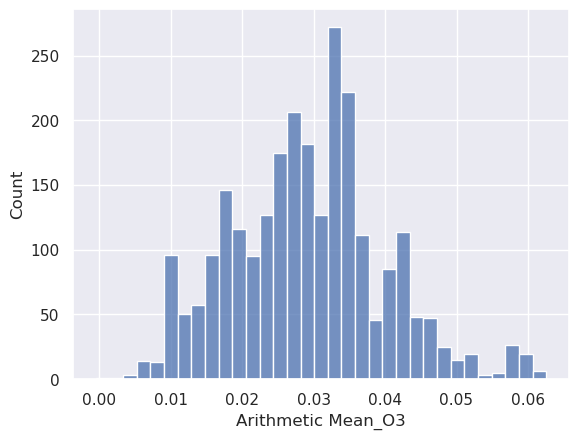

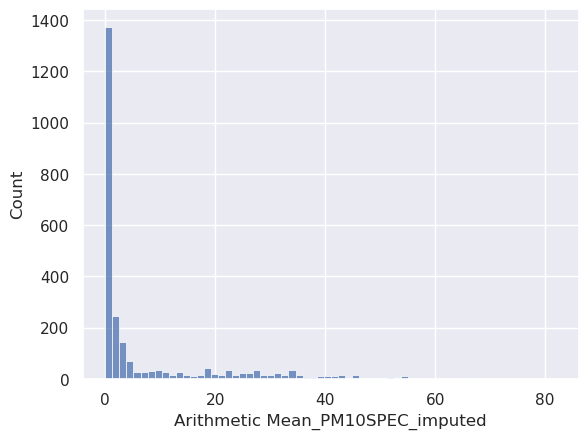

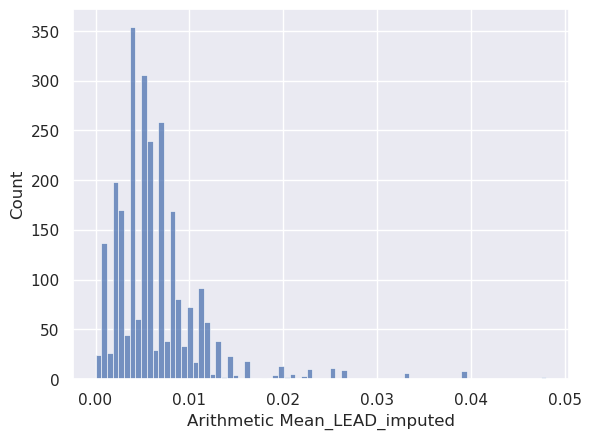

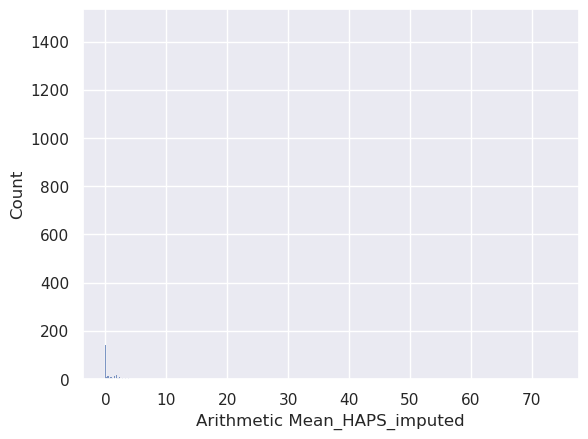

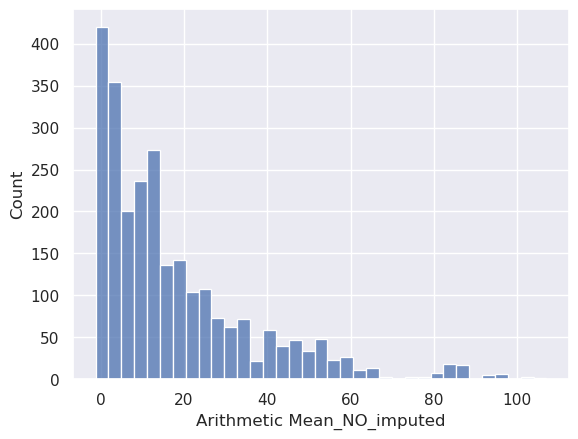

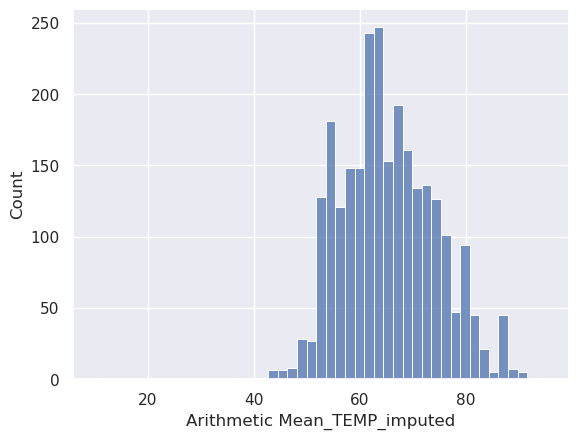

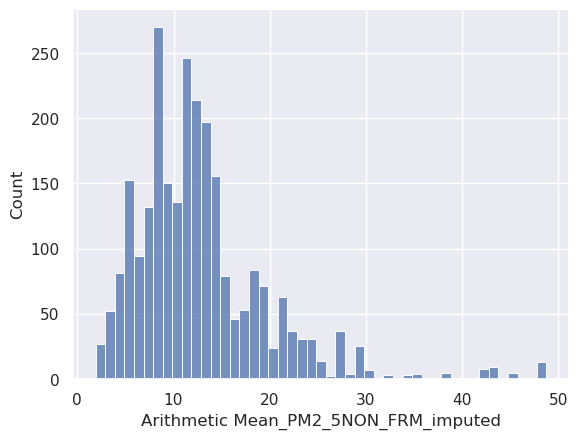

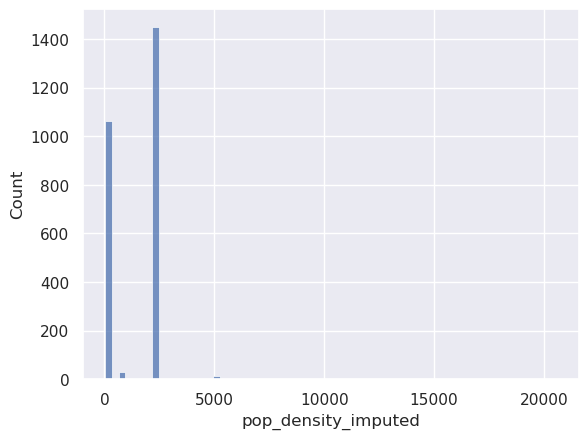

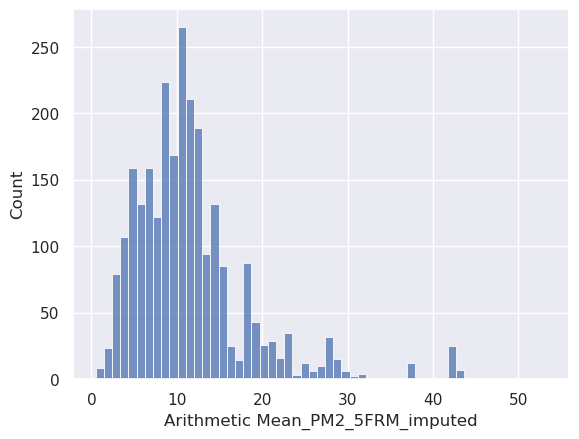

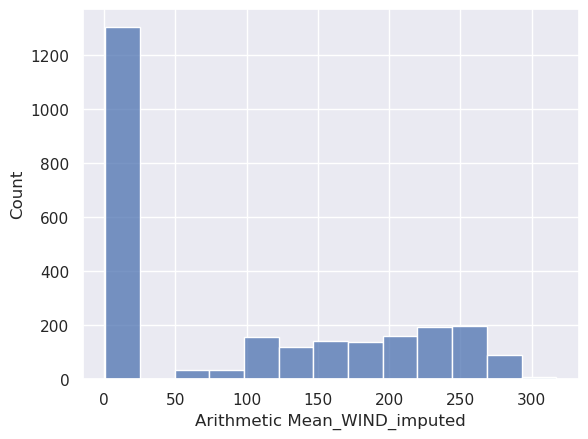

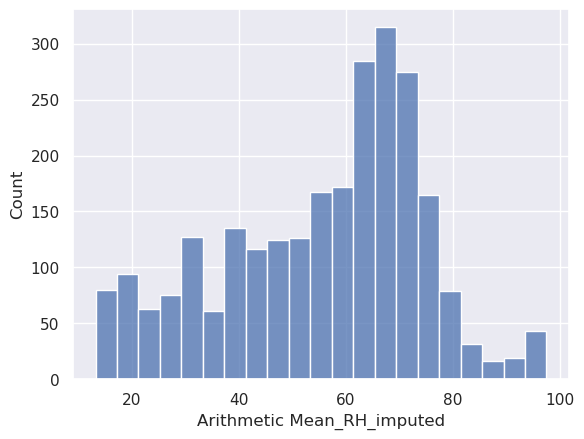

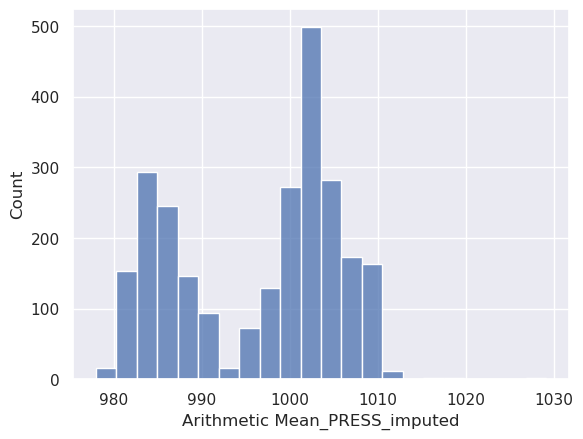

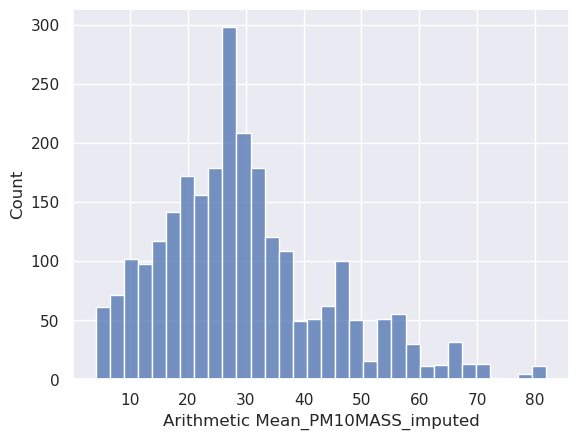

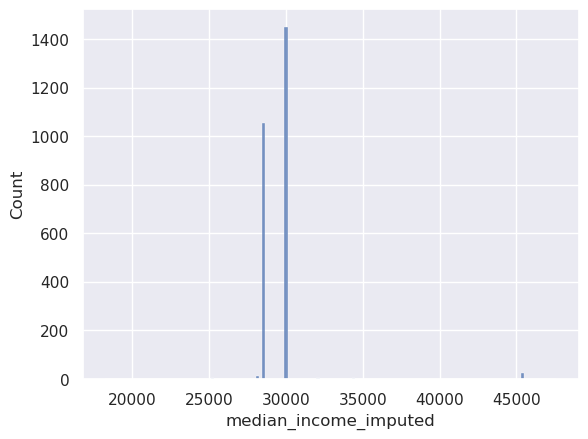

In [13]:
# Define columns to plot
vis_cols = ['Arithmetic Mean_CO', 'Arithmetic Mean_SO2', 'Arithmetic Mean_NO2', 'Arithmetic Mean_O3', 'Arithmetic Mean_PM10SPEC_imputed', 'Arithmetic Mean_LEAD_imputed',\
            'Arithmetic Mean_HAPS_imputed', 'Arithmetic Mean_NO_imputed', 'Arithmetic Mean_TEMP_imputed', 'Arithmetic Mean_PM2_5NON_FRM_imputed', 'pop_density_imputed',\
             'Arithmetic Mean_PM2_5FRM_imputed', 'Arithmetic Mean_WIND_imputed', 'Arithmetic Mean_RH_imputed', 'Arithmetic Mean_PRESS_imputed', 'Arithmetic Mean_PM10MASS_imputed',\
             'median_income_imputed']

for x in vis_cols: 
    plot = hist(x)

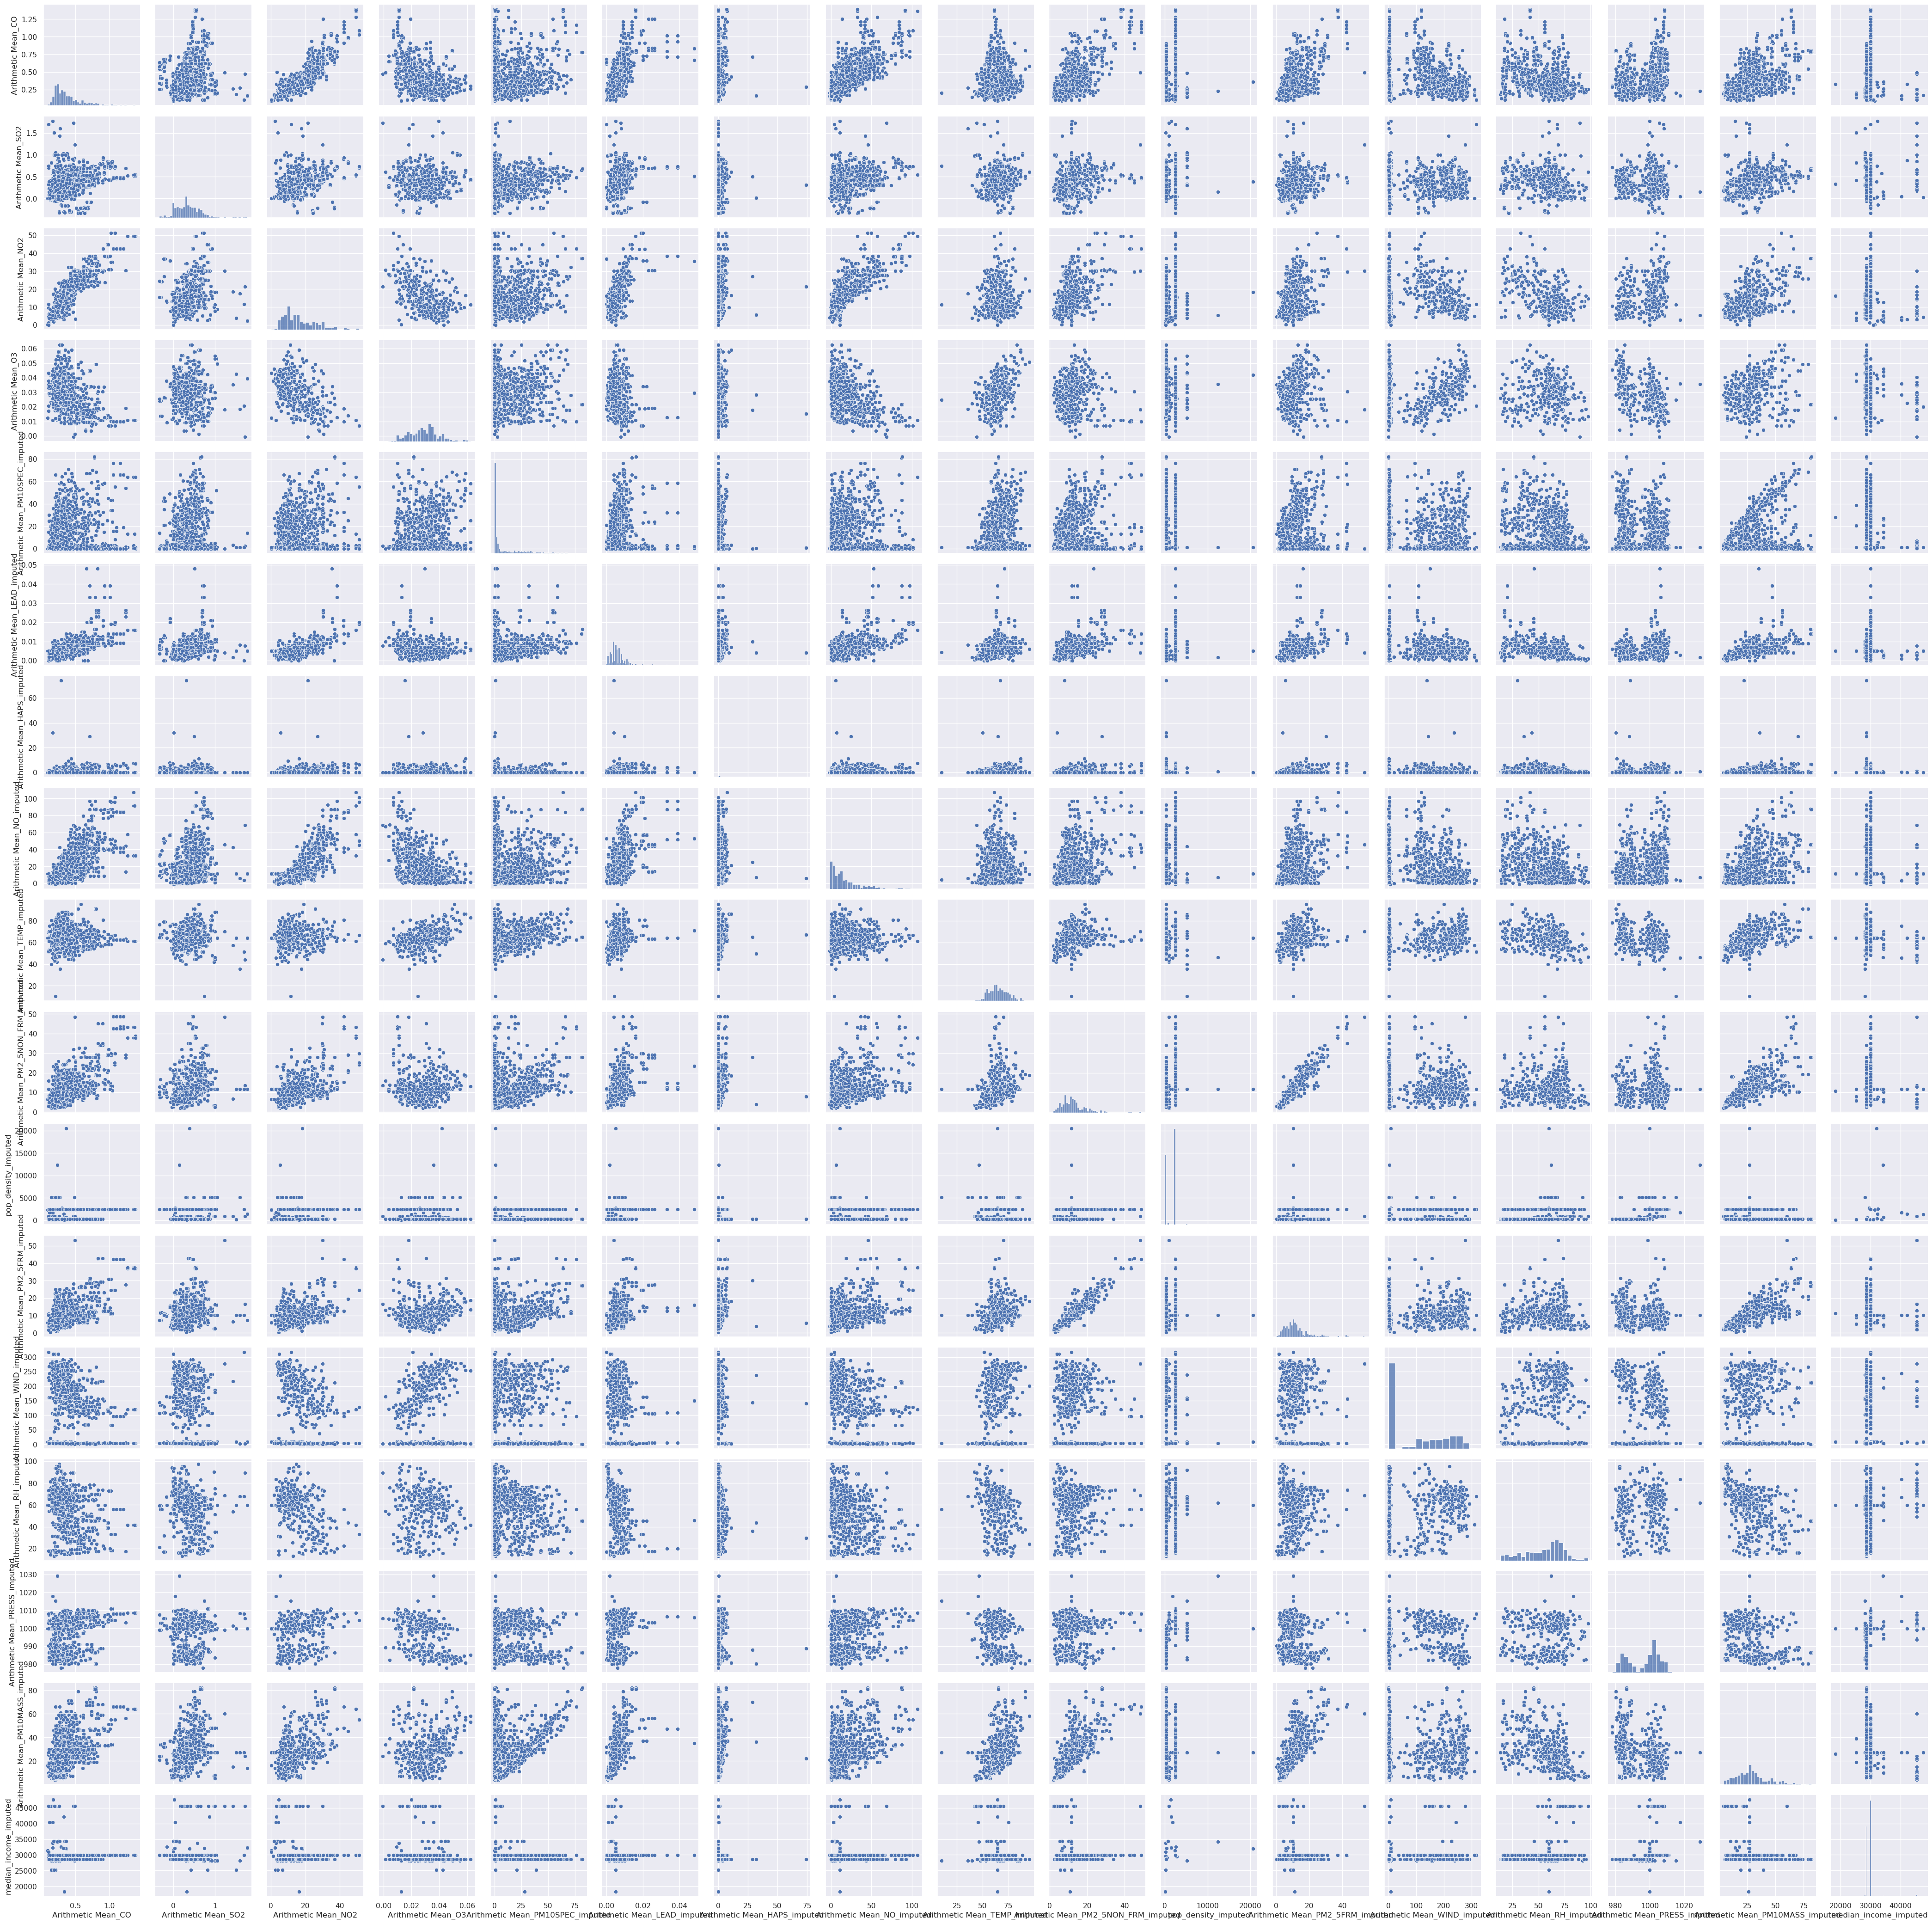

In [14]:
# Create pairwise table to look at correlations and distributions of whole data set 
# Create list of columns to feed to plot
pair_cols =  ['Arithmetic Mean_CO', 'Arithmetic Mean_SO2', 'Arithmetic Mean_NO2', 'Arithmetic Mean_O3', 'Arithmetic Mean_PM10SPEC_imputed', 'Arithmetic Mean_LEAD_imputed',\
            'Arithmetic Mean_HAPS_imputed', 'Arithmetic Mean_NO_imputed', 'Arithmetic Mean_TEMP_imputed', 'Arithmetic Mean_PM2_5NON_FRM_imputed', 'pop_density_imputed',\
             'Arithmetic Mean_PM2_5FRM_imputed', 'Arithmetic Mean_WIND_imputed', 'Arithmetic Mean_RH_imputed', 'Arithmetic Mean_PRESS_imputed', 'Arithmetic Mean_PM10MASS_imputed',\
             'median_income_imputed']

# Define pairgrid function and call plot 
g = sns.PairGrid(df_for_plot[pair_cols])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

# Data Splitting 

In [15]:
# Remove any remaining na values that may remain in the data set 
df = df.na.drop("any")

In [16]:
# Create 'general_AQI' column for binary regression
df = df.withColumn("General_AQI", when(df.AQI < 100.0 ,"Healthy").otherwise("Unhealthy"))

In [17]:
# Convert "General_AQI" for binary classification, 0.0 = 'Healthy', 1.0 = 'Unhealthy'
class_indexer = StringIndexer(inputCol="General_AQI", outputCol="class")

# Fit and transform the dataframe
df = class_indexer.fit(df).transform(df)

In [5]:
# For efficiency in running models on limited Rivanna time we have saved the data set as produced from the above code and import it here. 

#read in df_for_modeling, this data includes "General_AQI" and labeled point data for binary operations
df = spark.read.csv('df_for_modeling.csv',inferSchema = True, header = True)

In [6]:
# Split data approximately into sample (80%) and holdout (20%)
sample, holdout = df.randomSplit([0.8, 0.2], seed=314)

# Model Creation

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import *  
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils

## Research Question 1: 

### Predict air quality at county level for counties in the contiguous US using gas pollutant and particulate matter (PM) data


#### Model 0 

#### Pipeline Formation

Feature scaling is automatically performed on our data through the constructed pipeline.

In [10]:
# Create list of columns to pass to VectorAssembler
cols_mod0 = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3'] 

# Assemble predictors into feature column 
stage_1_mod0 = VectorAssembler(inputCols=cols_mod0,outputCol="features")

# Scale data for modeling 
stage_2_mod0 = StandardScaler(inputCol="features",outputCol="finalFeatures",withStd=True, withMean=True)

# Set up linear regression model 
stage_6_mod0 = LinearRegression(featuresCol="finalFeatures", labelCol='AQI')

# Create pipeline
# Previously we had additional stages that we eventually removed which is why there is no stage 3, 4, 5
pipeline_mod0 = Pipeline(stages=[stage_1_mod0, stage_2_mod0, stage_6_mod0])

#### Grid Formation

In [11]:
# Create parameter grid to pass to cross validator
paramGrid_mod0 = ParamGridBuilder() \
    .addGrid(stage_6_mod0.fitIntercept, [True, False])\
    .addGrid(stage_6_mod0.elasticNetParam, [0, 0.5, 1]) \
    .addGrid(stage_6_mod0.regParam, [10, 0.1, 0.01]) \
    .addGrid(stage_6_mod0.maxIter, [1, 5, 10]) \
    .build()

In [12]:
# Review how many models this will fit
print ('Number of models to be tested: ', len(paramGrid_mod0)) 

Number of models to be tested:  54


#### Cross Validator Creation

In [13]:
# Create the evaluator that will be passed to the cross validator. 
lrevaluator_mod0 = RegressionEvaluator(labelCol="AQI", metricName="rmse")

In [14]:
# Create cross validator
crossval_mod0 = CrossValidator(estimator=pipeline_mod0,
                          estimatorParamMaps=paramGrid_mod0,
                          evaluator=lrevaluator_mod0,
                          numFolds=5, 
                          seed = 314,
                          collectSubModels = True)

#### Model 0 Training: Linear Regression with K-folds Cross Validation Gas Only Columns

In [ ]:
# Fit sample data to cross validator model, compute in parallel
lrcvModel_mod0 = crossval_mod0.setParallelism(4).fit(sample)

In [14]:
# Extract the best model
mod0_best = lrcvModel_mod0.bestModel

In [15]:
# Extract parameters to view the best model
# Source: #https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark 
print('Best Param (regParam): ', mod0_best.stages[-1]._java_obj.getRegParam())
print('Best Param (MaxIter): ', mod0_best.stages[-1]._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', mod0_best.stages[-1]._java_obj.getElasticNetParam())

Best Param (regParam):  0.01
Best Param (MaxIter):  1
Best Param (elasticNetParam):  0.0


In [16]:
# Compute RMSE on sample data
lrcvModel_mod0.avgMetrics   #shows RMSE for all 54 models

[27.430916966328592,
 27.430916966328592,
 27.430916966328592,
 26.387177586494854,
 26.387177586494854,
 26.387177586494854,
 26.386873296669343,
 26.386873296669343,
 26.386873296669343,
 36.1715674048976,
 29.192047803888084,
 29.18609017443615,
 35.34698053267536,
 26.472985920128544,
 26.38885439579162,
 35.339558223929906,
 26.46730701291824,
 26.39283491715806,
 36.90078943140097,
 32.87493557489161,
 32.853976573911574,
 35.35523532402944,
 26.47253569548019,
 26.39123773637967,
 35.34038259711689,
 26.471899738887366,
 26.387423087982462,
 86.96882147109052,
 86.96882147109052,
 86.96882147109052,
 86.64525416840164,
 86.64525416840164,
 86.64525416840164,
 86.64516106850473,
 86.64516106850473,
 86.64516106850473,
 90.10830741408274,
 87.54025733747773,
 87.53826966182189,
 89.7804765790859,
 86.67142810738207,
 86.64576671199242,
 89.77755465452785,
 86.66968879555938,
 86.64699115854293,
 90.40350135778259,
 88.83626965371552,
 88.82851595207813,
 89.78372683432482,
 86.671

#### Model 0 Performance Evaluation on Holdout Data

In [17]:
# Fit model on holdout data
mod0_lr_preds = mod0_best.transform(holdout).select("AQI","prediction")

# Use RegressionEvaluator to compute RMSE on holdout data
lr_evaluator1 = RegressionEvaluator(predictionCol="prediction", labelCol="AQI",metricName="rmse")
# Use RegressionEvaluator to compute R^2 on holdout data
lr_evaluator2 = RegressionEvaluator(predictionCol="prediction", labelCol="AQI",metricName="r2")

# Print values
print("Model 0 RMSE on holdout data = %g" % lr_evaluator1.evaluate(mod0_lr_preds))
print("Model 0 R^2 on holdout data = %g" % lr_evaluator2.evaluate(mod0_lr_preds))

Model 0 RMSE on holdout data = 26.3718
Model 0 R^2 on holdout data = 0.510637


In [18]:
# Compute adjusted R^2
# Source: https://towardsdatascience.com/machine-learning-linear-regression-using-pyspark-9d5d5c772b42

# First compute R^2 from model 0
summary_r2 = lr_evaluator2.evaluate(mod0_lr_preds)
n = df.count()
p = len(df.columns)

# Compute adj R^2
adjusted_r2 = 1-(1 - summary_r2)*(n-1)/(n-p-1)

In [19]:
adjusted_r2

0.5106319524494112

---------------------------------------------------------------------------------------------------------------------------------------

### Model 1: 

#### Pipeline Formation

Feature scaling is automatically performed on our data through the constructed pipeline.

In [8]:
# Create list of columns to pass to VectorAssembler
cols = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3','Arithmetic Mean_PM10SPEC_imputed','Arithmetic Mean_LEAD_imputed',\
        'Arithmetic Mean_HAPS_imputed','Arithmetic Mean_NO_imputed','Arithmetic Mean_TEMP_imputed','Arithmetic Mean_PM2_5NON_FRM_imputed',\
        'Arithmetic Mean_PM2_5FRM_imputed', 'Arithmetic Mean_WIND_imputed','Arithmetic Mean_RH_imputed','Arithmetic Mean_PRESS_imputed',\
        'Arithmetic Mean_PM10MASS_imputed'] 

# Assemble predictors into feature column 
stage_1 = VectorAssembler(inputCols=cols,outputCol="features")

# Scale data for modeling 
stage_2 = StandardScaler(inputCol="features",outputCol="finalFeatures",withStd=True, withMean=True)

# Set up linear regression model 
stage_6 = LinearRegression(featuresCol="finalFeatures", labelCol='AQI')

# Create pipeline 
# Previously we had additional stages that we eventually removed which is why there is no stage 3, 4, 5
pipeline = Pipeline(stages=[stage_1, stage_2, stage_6])

#### Grid Formation

In [9]:
# Create parameter grid to pass to cross validator
paramGrid = ParamGridBuilder() \
    .addGrid(stage_6.fitIntercept, [True, False])\
    .addGrid(stage_6.elasticNetParam, [0, 0.5, 1]) \
    .addGrid(stage_6.regParam, [10, 0.1, 0.01]) \
    .addGrid(stage_6.maxIter, [1, 5, 10]) \
    .build()

In [10]:
# Review how many models this will fit
print ('Number of models to be tested: ', len(paramGrid)) #this can be removed later 

Number of models to be tested:  54


#### Cross Validator Creation

In [11]:
# Create the evaluator that will be passed to the cross validator. 
lrevaluator = RegressionEvaluator(labelCol="AQI", metricName="rmse")

In [12]:
# Create cross validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=lrevaluator,
                          numFolds=5, 
                          seed = 314,
                          collectSubModels=True)

#### Model 1 Training: Linear Regression with 5-fold Cross Validation

In [13]:
# Fit cross validator to sample data, run in parallel
lrcvModel_mod1 = crossval.setParallelism(4).fit(sample)

In [14]:
# Extract the best model
mod1_best = lrcvModel_mod1.bestModel

In [15]:
# Extract parameters to view the best model
print('Best Param (regParam): ', mod1_best.stages[-1]._java_obj.getRegParam())
print('Best Param (MaxIter): ', mod1_best.stages[-1]._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', mod1_best.stages[-1]._java_obj.getElasticNetParam())

Best Param (regParam):  0.01
Best Param (MaxIter):  1
Best Param (elasticNetParam):  0.0


In [16]:
# Show RMSE values for sample data
lrcvModel_mod1.avgMetrics   #shows RMSE for all 54 models

[22.194471998782777,
 22.194471998782777,
 22.194471998782777,
 21.810651276176884,
 21.810651276176884,
 21.810651276176884,
 21.810505544673624,
 21.810505544673624,
 21.810505544673624,
 35.90684205276305,
 23.934828214193367,
 23.83708284156272,
 35.201747746629415,
 22.041905798883228,
 21.85796388542103,
 35.19532408527833,
 22.11194746749025,
 21.822771010842963,
 36.54960262486295,
 26.75592542138505,
 26.5298917989332,
 35.20888861831198,
 22.042878123991454,
 21.838847312496892,
 35.19603767926219,
 22.111737505064696,
 21.822084166884274,
 85.46170770435117,
 85.46170770435117,
 85.46170770435117,
 85.3628206349025,
 85.3628206349025,
 85.3628206349025,
 85.36278344946643,
 85.36278344946643,
 85.36278344946643,
 90.00236760537476,
 85.93015142781488,
 85.9029931192672,
 89.7233946004254,
 85.42220056667958,
 85.37493375380492,
 89.7208745297522,
 85.44030539280784,
 85.36589568667875,
 90.26072591352849,
 86.75832718333503,
 86.68813207451012,
 89.72619649701426,
 85.422448

#### Model 1 Performance Evaluation 

In [17]:
# Fit model on holdout data
mod1_lr_preds = mod1_best.transform(holdout)

# Select columns 'prediction','AQI','features' to view
mod1_lr_preds.select("prediction","AQI","features").show(5)

# Use RegressionEvaluator to compute RMSE on holdout data
lr_evaluator1 = RegressionEvaluator(predictionCol="prediction", labelCol="AQI",metricName="rmse")
# Use RegressionEvaluator to compute R^2 on holdout data
lr_evaluator2 = RegressionEvaluator(predictionCol="prediction", labelCol="AQI",metricName="r2")

# Print values
print("Model 1 RMSE on holdout data = %g" % lr_evaluator1.evaluate(mod1_lr_preds))
print("Model 1 R^2 on holdout data = %g" % lr_evaluator2.evaluate(mod1_lr_preds))

+------------------+-----+--------------------+
|        prediction|  AQI|            features|
+------------------+-----+--------------------+
| 84.52527409178191| 53.0|[0.2,0.8625,4.775...|
| 63.82739584475725| 55.0|[0.238889,0.13043...|
|54.179216556094474|145.0|[0.331579,0.3,16....|
|54.150090305871714|145.0|[0.331579,0.3,16....|
| 54.68586016564142|145.0|[0.331579,0.3,16....|
+------------------+-----+--------------------+
only showing top 5 rows

Model 1 RMSE on holdout data = 21.7922
Model 1 R^2 on holdout data = 0.665841


In [18]:
# Compute adjusted R^2
# First compute R^2 
summary_r2 = lr_evaluator2.evaluate(mod1_lr_preds)
n = holdout.count()
p = len(cols)

#Compute adj R^2
adjusted_r2 = 1-(1 - summary_r2)*(n-1)/(n-p-1)
print("Model 1 Adjusted-R^2 on holdout data = %g" % adjusted_r2)

Model 1 Adjusted-R^2 on holdout data = 0.665832


-----------------------------

### Model 2: Random Forest

#### Pipeline Formation

Feature scaling is automatically performed on our data through the constructed pipeline.

In [8]:
# Create list of columns to pass to VectorAssembler
cols_rf1 = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3','Arithmetic Mean_PM10SPEC_imputed','Arithmetic Mean_LEAD_imputed',\
        'Arithmetic Mean_HAPS_imputed','Arithmetic Mean_NO_imputed','Arithmetic Mean_TEMP_imputed','Arithmetic Mean_PM2_5NON_FRM_imputed',\
        'Arithmetic Mean_PM2_5FRM_imputed', 'Arithmetic Mean_WIND_imputed','Arithmetic Mean_RH_imputed','Arithmetic Mean_PRESS_imputed',\
        'Arithmetic Mean_PM10MASS_imputed']

# Assemble predictors into feature column 
assemble = VectorAssembler(inputCols=cols_rf1,outputCol="features")

# Run features through indexer  
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=6)

# Set up random forest model 
rf = RandomForestRegressor(labelCol= 'AQI', featuresCol="indexedFeatures", )

# Create pipeline
pipeline_rf1 = Pipeline(stages=[assemble, featureIndexer, rf])

# Source: https://www.silect.is/blog/random-forest-models-in-spark-ml/ 

#### Grid Formation

In [9]:
# Create parameter grid to pass to cross validator
paramGrid_rf1 = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 20, 50])\
    .addGrid(rf.maxDepth, [2, 5, 10])\
    .build()

#### Cross Validator Creation

In [10]:
# Create the evaluator that will be passed to the cross validator. 
rfEvaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction",  metricName="rmse") 
rfEvaluator_r2 = RegressionEvaluator(labelCol="AQI", predictionCol="prediction",  metricName="r2") 

In [11]:
# Create cross validator
crossval_rf1 = CrossValidator(estimator=pipeline_rf1,
                          estimatorParamMaps=paramGrid_rf1,
                          evaluator=rfEvaluator,
                          numFolds=3)

In [12]:
# Fit crossvalidator to sample data, compute in parallel
rf_model1 = crossval_rf1.setParallelism(4).fit(sample) 

In [13]:
# Show metrics from models 
rf_model1.avgMetrics

[23.34881055947425,
 14.403729879917218,
 3.787545047143249,
 23.68723365730348,
 13.841937474511298,
 3.60155686969229,
 24.110016836381597,
 13.660143640709055,
 3.3093559443558753]

In [14]:
# Select best model
bestPipeline = rf_model1.bestModel

In [15]:
# Extract parameters to view the best model
print('RF1 Best Param (Num Trees): ', bestPipeline.stages[-1]._java_obj.getNumTrees())
print('RF1 Best Param (Max Depth): ', bestPipeline.stages[-1]._java_obj.getMaxDepth())

RF1 Best Param (Num Trees):  50
RF1 Best Param (Max Depth):  10


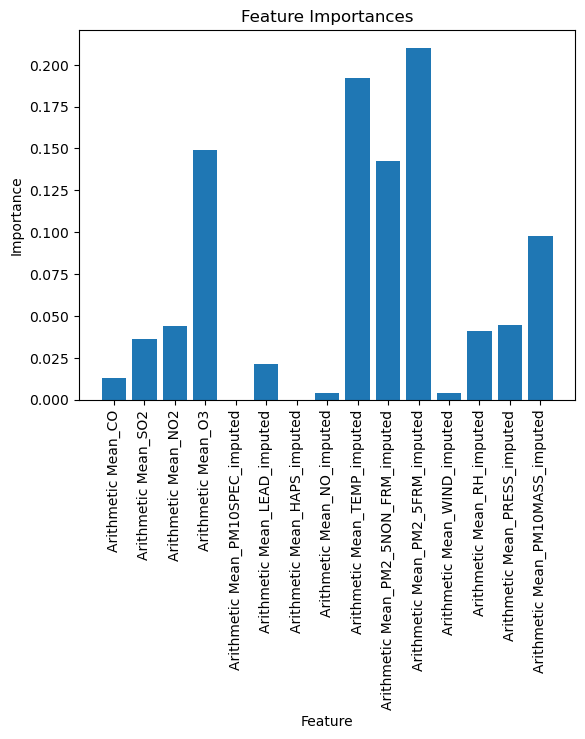

In [16]:
# Create feature importance graph 
bestModel = bestPipeline.stages[2]

# Extract importances
importances = bestModel.featureImportances

# Create list of importances to pass to function 
x_values = list(range(len(importances)))

# Create bar plot 
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, cols_rf1, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')
plt.show()

# Source https://www.silect.is/blog/random-forest-models-in-spark-ml/

#### Model 2 Performance Evaluation 

In [17]:
# Fit RF model on holdout data
prediction_rf1 = rf_model1.transform(holdout) 

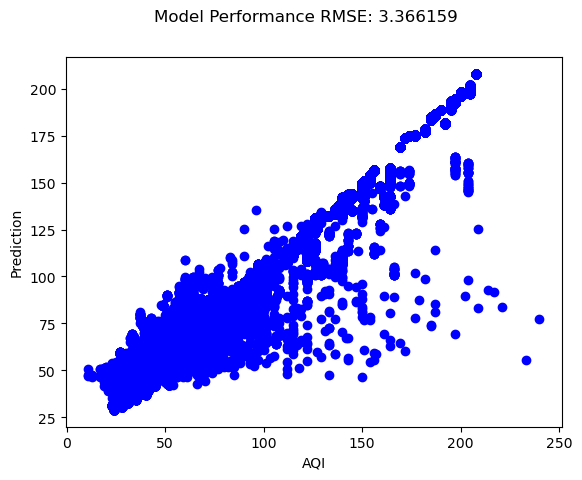

In [18]:
# Create scatterplot that shows prediction vs true value, display RMSE 

# Call evaluator on test data 
rmse = rfEvaluator.evaluate(prediction_rf1)

# Convert to pandas df for graphing 
rfResult = prediction_rf1.toPandas()

# Create plot 
plt.plot(rfResult.AQI, rfResult.prediction, 'bo')
plt.xlabel('AQI')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

# Adapted from: https://www.silect.is/blog/random-forest-models-in-spark-ml/

In [22]:
# Compute adjusted R^2
# First compute R^2 from model 0
summary_r2 = rfEvaluator_r2.evaluate(prediction_rf1)
n = holdout.count()
p = len(cols_rf1)

# Compute adj r^2
adjusted_r2 = 1-(1 - summary_r2)*(n-1)/(n-p-1)
print("Model 2 R^2 on holdout data = %g" % summary_r2)
#print("Model 2 Adjusted-R^2 on holdout data = %g" % adjusted_r2)

Model 2 R^2 on holdout data = 0.992029


-------------------------

### Model 3: Binary Logistic Regression AQI Healthy / Unhealthy

#### Pipeline Formation

Feature scaling is automatically performed on our data through the constructed pipeline.

In [8]:
# Select feature columns to include in binary logistic model
cols_log = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3','Arithmetic Mean_PM10SPEC_imputed',\
            'Arithmetic Mean_LEAD_imputed','Arithmetic Mean_HAPS_imputed','Arithmetic Mean_NO_imputed','Arithmetic Mean_TEMP_imputed',\
            'Arithmetic Mean_PM2_5NON_FRM_imputed','Arithmetic Mean_PM2_5FRM_imputed', 'Arithmetic Mean_WIND_imputed','Arithmetic Mean_RH_imputed',\
            'Arithmetic Mean_PRESS_imputed','Arithmetic Mean_PM10MASS_imputed']  #still not including socio-economic data

# Use VectorAssembler to create the features column
stage_1_log = VectorAssembler(inputCols=cols_log, outputCol="features")
# Use StandardScaler to scale each feature
stage_2_log = StandardScaler(inputCol="features", outputCol="finalFeatures",withStd=True, withMean=True)

# Set-up logistic regression with 'class' as target variable and finalFeatures
stage_3_log = LogisticRegression(labelCol = "class", featuresCol = "finalFeatures", maxIter=10)

# Set-up pipeline object to run through each stage of modeling
pipeline_log = Pipeline(stages=[stage_1_log, stage_2_log, stage_3_log])

#### Grid Formation

In [9]:
# Define parameter grid
paramGrid_log = ParamGridBuilder()  \
                .addGrid(stage_3_log.maxIter, [1, 5, 10])  \
                .addGrid(stage_3_log.regParam, [0.01, 0.1, 1.0]) \
                .addGrid(stage_3_log.elasticNetParam, [0.0, 0.5, 1.0])  \
                .build()

#### Cross Validator Creation

In [10]:
# Set-up binary logistic regression model evaluator
log_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='class')

In [11]:
# Set-up cross validation pipeline, parameter grid, evaluator, 5-folds, seed=314, keep the sub models created
crossval_log = CrossValidator(estimator=pipeline_log,
                              estimatorParamMaps=paramGrid_log,
                              evaluator=log_evaluator,
                              numFolds=5,
                              seed=314,
                              collectSubModels=True)

In [ ]:
# Fit binary logistic regression model to the sample data, run in parallel
log_rg = crossval_log.setParallelism(4).fit(sample) 

In [13]:
# Extract the best model
log_best = log_rg.bestModel

In [ ]:
# Extract parameters to view the best model
print('Logit Best Param (regParam): ', log_best.stages[-1]._java_obj.getRegParam())
print('Logit Param (MaxIter): ', log_best.stages[-1]._java_obj.getMaxIter())
print('Logit Param (elasticNetParam): ', log_best.stages[-1]._java_obj.getElasticNetParam())

In [15]:
# Can list coefficients of the best model
log_best.stages[-1].coefficients

DenseVector([-0.0018, 0.5338, -0.6857, 0.7787, 0.0005, 0.4022, 0.0411, -0.0874, 0.6792, 0.6777, 0.5991, 0.056, -0.0672, -0.1941, 0.1122])

### Model 3 Performance Evaluation 

In [17]:
# Make predictions on holdout data using best logistic regression model
preds_log = log_best.transform(holdout)

In [18]:
#this works, just prints a ton of records!!
#selected = preds_log.select("date local", "class", "probability", "prediction")
#for row in selected.collect():
#    print(row)

In [19]:
# Create both evaluators
predsRDD = preds_log.select(['class', 'prediction']).rdd.map(lambda line: (line[1], line[0]))

metrics_binary = BinaryClassificationMetrics(predsRDD)
metrics_multi = MulticlassMetrics(predsRDD)

acc = metrics_multi.accuracy
f1 = metrics_multi.fMeasure(1.0)
precision = metrics_multi.precision(1.0)
recall = metrics_multi.recall(1.0)
auc = metrics_binary.areaUnderROC

In [20]:
# Confusion Matrix
print(metrics_multi.confusionMatrix().toArray())

# Overall statistics
print("Model 3 Logit Accuracy on holdout data = %g" % acc)
print("Model 3 Logit Precision on holdout data = %g" %precision)
print("Model 3 Logit F1 on holdout data = %g" % f1)
print("Model 3 Logit Recall on holdout data = %g" % recall)
print("Model 3 Logit AUROC on holdout data = %g" % auc)

[[352875.  25872.]
 [ 55021.  96173.]]
Model 3 Logit Accuracy on holdout data = 0.847355
Model 3 Logit Precision on holdout data = 0.788013
Model 3 Logit F1 on holdout data = 0.703948
Model 3 Logit Recall on holdout data = 0.63609
Model 3 Logit AUROC on holdout data = 0.78389


In [21]:
# Define ROC curve function 
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        roc = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            roc += [(float(row._1()), float(row._2()))]
        return roc

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
# Source: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

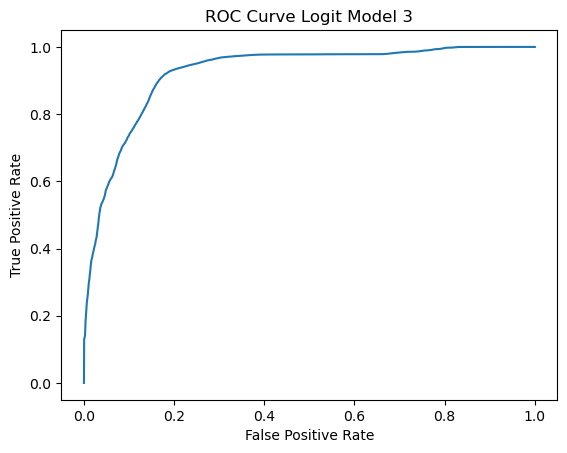

In [22]:
# Create ROC curve 

# Returns as a list (false positive rate, true positive rate)
preds = preds_log.select('class','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['class'])))
roc = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in roc]
y_val = [x[1] for x in roc]
plt.title('ROC Curve Logit Model 3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)
plt.show()

In [27]:
# Use RegressionEvaluator to compute RMSE on holdout data
binaryclass_evaluator1 = BinaryClassificationEvaluator(rawPredictionCol="prediction", \
                                         labelCol="class",metricName="areaUnderROC")

binaryclass_evaluator2 = BinaryClassificationEvaluator(rawPredictionCol="prediction", \
                                         labelCol="class",metricName="areaUnderPR")

# Print values
print("AUROC on holdout data = %g" % binaryclass_evaluator1.evaluate(preds_log))
print("AU PR Curve on holdout data = %g" % binaryclass_evaluator2.evaluate(preds_log))

AUROC on holdout data = 0.78389
AU PR Curve on holdout data = 0.696542


----------------------

## Research Question 2

### Predict air quality at county level with gas pollutant and particulate matter data and socio-economic factors

### Model 4: 

#### Pipeline Formation

Feature scaling is automatically performed on our data through the constructed pipeline.

In [9]:
# Select features for modeling, this model includes socio-economic features 'median_income_imputed' and 'pop_density_imputed'
cols_mod4 = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3', 'median_income_imputed', 'pop_density_imputed'] 

# Assemble predictors into feature column
stage_1_mod4 = VectorAssembler(inputCols=cols_mod4,outputCol="features")

# Scale data for modeling 
stage_2_mod4 = StandardScaler(inputCol="features",outputCol="finalFeatures",withStd=True, withMean=True)

# Set up linear regression model 
stage_6_mod4 = LinearRegression(featuresCol="finalFeatures", labelCol='AQI')

# Create pipeline 
# Previously we had additional stages that we eventually removed which is why there is no stage 3, 4, 5
pipeline_mod4 = Pipeline(stages=[stage_1_mod4, stage_2_mod4, stage_6_mod4])

#### Grid Formation

In [10]:
# Create parameter grid to pass to cross validator
paramGrid_mod4 = ParamGridBuilder() \
    .addGrid(stage_6_mod4.fitIntercept, [True, False])\
    .addGrid(stage_6_mod4.elasticNetParam, [0, 0.5, 1]) \
    .addGrid(stage_6_mod4.regParam, [10, 0.1, 0.01]) \
    .addGrid(stage_6_mod4.maxIter, [1, 5, 10]) \
    .build()

#### Cross Validator Creation

In [11]:
# Create the evaluator that will be passed to the cross validator. 
lrevaluator_mod4 = RegressionEvaluator(labelCol="AQI", metricName="rmse")

In [12]:
# Create cross validator
crossval_mod4 = CrossValidator(estimator=pipeline_mod4,
                               estimatorParamMaps=paramGrid_mod4,
                               evaluator=lrevaluator_mod4,
                               numFolds=5, 
                               seed = 314)

#### Model 4 Training: Linear Regression with K-folds Cross Validation Gas and Socio-Economic Columns

In [13]:
# Fit linear regression model 
lrcvModel_mod4 = crossval_mod4.setParallelism(4).fit(sample)

In [14]:
# Show model metrics for all models fit by cross validator 
lrcvModel_mod4.avgMetrics

[27.30733316355027,
 27.30733316355027,
 27.30733316355027,
 26.25440154520158,
 26.25440154520158,
 26.25440154520158,
 26.254101172717444,
 26.254101172717444,
 26.254101172717444,
 36.21111570809724,
 29.188673800543484,
 29.182393071531155,
 35.28629718712591,
 26.322727258295174,
 26.263490203681627,
 35.27795314286988,
 26.31882888749644,
 26.265041336917683,
 36.92458029126663,
 32.87652129936025,
 32.85024460322486,
 35.295579891702424,
 26.31351880818754,
 26.258625467662554,
 35.27887977259249,
 26.33053192422932,
 26.270786396452184,
 86.92878347111102,
 86.92878347111102,
 86.92878347111102,
 86.6037704131162,
 86.6037704131162,
 86.6037704131162,
 86.60367894452938,
 86.60367894452938,
 86.60367894452938,
 90.1231033329822,
 87.53800964690487,
 87.53591525277815,
 89.7555108393712,
 86.62458685658837,
 86.606304866649,
 89.75223082290125,
 86.62334175466454,
 86.60724598148886,
 90.41213421093339,
 88.83575977063673,
 88.82603431381477,
 89.75916061077821,
 86.621720051221

In [15]:
# Extract best model
mod4_best = lrcvModel_mod4.bestModel

In [16]:
# Extract parameters to view the best model
# Source: #https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark 
print('Model 4 Best Param (regParam): ', mod4_best.stages[-1]._java_obj.getRegParam())
print('Model 4 Best Param (MaxIter): ', mod4_best.stages[-1]._java_obj.getMaxIter())
print('Model 4 Best Param (elasticNetParam): ', mod4_best.stages[-1]._java_obj.getElasticNetParam())

Model 4 Best Param (regParam):  0.01
Model 4 Best Param (MaxIter):  1
Model 4 Best Param (elasticNetParam):  0.0


In [17]:
# Evaluate model on sample data
preds_mod4_samp = mod4_best.transform(sample)

#### Model 4 Performance Evaluation 

In [18]:
# Fit model on holdout data
mod4_lr_preds = mod4_best.transform(holdout)
# Select columns 'prediction','AQI','features' to view
mod4_lr_preds.select("prediction","AQI","features").show(5)

# Use RegressionEvaluator to compute RMSE on holdout data
lr_evaluator1 = RegressionEvaluator(predictionCol="prediction", labelCol="AQI",metricName="rmse")
# Use RegressionEvaluator to compute R^2 on holdout data
lr_evaluator2 = RegressionEvaluator(predictionCol="prediction", labelCol="AQI",metricName="r2")

# Print values
print("Model 4 RMSE on holdout data = %g" % lr_evaluator1.evaluate(mod4_lr_preds))
print("Model 4 R^2 on holdout data = %g" % lr_evaluator2.evaluate(mod4_lr_preds))

+------------------+-----+--------------------+
|        prediction|  AQI|            features|
+------------------+-----+--------------------+
| 84.22399422775067| 53.0|[0.2,0.8625,4.775...|
|39.199912018013386| 55.0|[0.238889,0.13043...|
| 55.29737008603083|145.0|[0.331579,0.3,16....|
| 55.29737008603083|145.0|[0.331579,0.3,16....|
| 55.29737008603083|145.0|[0.331579,0.3,16....|
+------------------+-----+--------------------+
only showing top 5 rows

Model 4 RMSE on holdout data = 26.2621
Model 4 R^2 on holdout data = 0.514818


In [19]:
# Compute adjusted R^2
# First compute R^2 
summary_r2 = lr_evaluator2.evaluate(mod4_lr_preds)
n = holdout.count()
p = len(cols_mod4)

#Compute adj r^2
adjusted_r2 = 1-(1 - summary_r2)*(n-1)/(n-p-1)
print("Model 4 Adjusted-R^2 on holdout data = %g" % adjusted_r2)

Model 4 Adjusted-R^2 on holdout data = 0.514812


### Model 5: 

#### Pipeline Formation

Feature scaling is automatically performed on our data through the constructed pipeline.

In [9]:
# Create list of columns to pass to VectorAssembler
cols_mod5 = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3','Arithmetic Mean_PM10SPEC_imputed','Arithmetic Mean_LEAD_imputed',\
        'Arithmetic Mean_HAPS_imputed','Arithmetic Mean_NO_imputed','Arithmetic Mean_TEMP_imputed','Arithmetic Mean_PM2_5NON_FRM_imputed',\
        'Arithmetic Mean_PM2_5FRM_imputed', 'Arithmetic Mean_WIND_imputed','Arithmetic Mean_RH_imputed','Arithmetic Mean_PRESS_imputed',\
        'Arithmetic Mean_PM10MASS_imputed', 'median_income_imputed', 'pop_density_imputed']

# Assemble predictors into feature column 
stage_1_mod5 = VectorAssembler(inputCols=cols_mod5,outputCol="features")

# Scale data for modeling 
stage_2_mod5 = StandardScaler(inputCol="features",outputCol="finalFeatures",withStd=True, withMean=True)

# Set up linear regression model 
stage_6_mod5 = LinearRegression(featuresCol="finalFeatures", labelCol='AQI')

# Create pipeline 
# Previously we had additional stages that we eventually removed which is why there is no stage 3, 4, 5
pipeline_mod5 = Pipeline(stages=[stage_1_mod5, stage_2_mod5, stage_6_mod5])

#### Grid Formation

In [10]:
# Create parameter grid to pass to cross validator
paramGrid_mod5 = ParamGridBuilder() \
    .addGrid(stage_6_mod5.fitIntercept, [True, False])\
    .addGrid(stage_6_mod5.elasticNetParam, [0, 0.5, 1]) \
    .addGrid(stage_6_mod5.regParam, [10, 0.1, 0.01]) \
    .addGrid(stage_6_mod5.maxIter, [1, 5, 10]) \
    .build()

#### Cross Validator Creation

In [11]:
# Create the evaluator that will be passed to the cross validator. 
lrevaluator_mod5 = RegressionEvaluator(labelCol="AQI", metricName="rmse")

In [12]:
# Create cross validator
crossval_mod5 = CrossValidator(estimator=pipeline_mod5,
                          estimatorParamMaps=paramGrid_mod5,
                          evaluator=lrevaluator_mod5,
                          numFolds=5, 
                          seed = 314)

#### Model 5 Training: Linear Regression with K-folds Cross Validation All Gas, Particulate Matter, and Socio-Economic Columns 

In [13]:
# Fit model 
lrcvModel_mod5 = crossval_mod5.setParallelism(4).fit(sample)

In [14]:
# Extract the best model
mod5_best = lrcvModel_mod5.bestModel

In [15]:
# Extract parameters to view the best model
print('Best Param (regParam): ', mod5_best.stages[-1]._java_obj.getRegParam())
print('Best Param (MaxIter): ', mod5_best.stages[-1]._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', mod5_best.stages[-1]._java_obj.getElasticNetParam())

Best Param (regParam):  0.01
Best Param (MaxIter):  1
Best Param (elasticNetParam):  0.0


In [16]:
# Get model performance of all models fit by the cross validator 
lrcvModel_mod5.avgMetrics

[22.17618633678249,
 22.17618633678249,
 22.17618633678249,
 21.79215009482367,
 21.79215009482367,
 21.79215009482367,
 21.79199292468421,
 21.79199292468421,
 21.79199292468421,
 35.9174513379529,
 23.927005180865137,
 23.835659328721114,
 35.18656880211064,
 22.005155387372852,
 21.820212724433432,
 35.17988023424584,
 22.0381108091049,
 21.820201596941764,
 36.55731002815194,
 26.75846767495938,
 26.709319730512785,
 35.19400441099278,
 22.004780157746744,
 21.82647761081998,
 35.18062324557804,
 22.038099818735255,
 21.82021670637212,
 85.45695946239033,
 85.45695946239033,
 85.45695946239033,
 85.35809250300804,
 85.35809250300804,
 85.35809250300804,
 85.35805233920092,
 85.35805233920092,
 85.35805233920092,
 90.00660054581525,
 85.92797481176433,
 85.90260896889147,
 89.71743997522691,
 85.41272154326259,
 85.36577317843803,
 89.71481694465538,
 85.42122554017456,
 85.36544339570447,
 90.26384718231107,
 86.75919878009849,
 86.7439778438532,
 89.72035646531026,
 85.41263400928

### Model 5 Performance Evaluation 

In [17]:
# Get predictions on test data 
prediction_model5 = lrcvModel_mod5.transform(holdout) 

In [18]:
# Fit model on holdout data
mod5_lr_preds = mod5_best.transform(holdout)

# Select columns 'prediction','AQI','features' to view
mod5_lr_preds.select("prediction","AQI","features").show(5)

# Use RegressionEvaluator to compute RMSE on holdout data
lr_evaluator_5_1 = RegressionEvaluator(predictionCol="prediction", labelCol="AQI",metricName="rmse")
# Use RegressionEvaluator to compute R^2 on holdout data
lr_evaluator_5_2 = RegressionEvaluator(predictionCol="prediction", labelCol="AQI",metricName="r2")

# Print values
print("Model 5 RMSE on holdout data = %g" % lr_evaluator_5_1.evaluate(mod5_lr_preds))
print("Model 5 R^2 on holdout data = %g" % lr_evaluator_5_2.evaluate(mod5_lr_preds))

+------------------+-----+--------------------+
|        prediction|  AQI|            features|
+------------------+-----+--------------------+
| 83.39577757357031| 53.0|[0.2,0.8625,4.775...|
| 65.25003039122423| 55.0|[0.238889,0.13043...|
|54.637234652532484|145.0|[0.331579,0.3,16....|
| 54.63673304567844|145.0|[0.331579,0.3,16....|
| 55.13994385472675|145.0|[0.331579,0.3,16....|
+------------------+-----+--------------------+
only showing top 5 rows

Model 5 RMSE on holdout data = 21.7723
Model 5 R^2 on holdout data = 0.666449


In [19]:
# Compute adjusted R^2
# First compute R^2 
summary_mod5_r2 = lr_evaluator_5_2.evaluate(mod5_lr_preds)
n = holdout.count()
p = len(cols_mod5)

# Compute adj r^2
adjusted_mod5_r2 = 1-(1 - summary_mod5_r2)*(n-1)/(n-p-1)
print("Model 5 Adjusted-R^2 on holdout data = %g" % adjusted_mod5_r2)

Model 5 Adjusted-R^2 on holdout data = 0.666446


### Model 6: 

#### Pipeline Formation

Feature scaling is automatically performed on our data through the constructed pipeline.

In [9]:
# Create list of columns to pass to VectorAssembler
cols_rf2 = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3','Arithmetic Mean_PM10SPEC_imputed','Arithmetic Mean_LEAD_imputed',\
        'Arithmetic Mean_HAPS_imputed','Arithmetic Mean_NO_imputed','Arithmetic Mean_TEMP_imputed','Arithmetic Mean_PM2_5NON_FRM_imputed',\
        'Arithmetic Mean_PM2_5FRM_imputed', 'Arithmetic Mean_WIND_imputed','Arithmetic Mean_RH_imputed','Arithmetic Mean_PRESS_imputed',\
        'Arithmetic Mean_PM10MASS_imputed', 'median_income_imputed', 'pop_density_imputed']

# Assemble predictors into feature column 
assemble_rf2 = VectorAssembler(inputCols=cols_rf2,outputCol="features")

# Run features through indexer  
featureIndexer_rf2 = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=6)

# Set up random forest model 
rf2 = RandomForestRegressor(labelCol= 'AQI', featuresCol="indexedFeatures", )

# Create pipeline 
pipeline_rf2 = Pipeline(stages=[assemble_rf2, featureIndexer_rf2, rf2])

# Source: https://www.silect.is/blog/random-forest-models-in-spark-ml/ 

#### Grid Formation

In [10]:
# Create parameter grid to pass to cross validator
paramGrid_rf2 = ParamGridBuilder() \
    .addGrid(rf2.numTrees, [5, 20, 50])\
    .addGrid(rf2.maxDepth, [2, 5, 10])\
    .build()

#### Cross Validator Creation

In [11]:
# Create the evaluator that will be passed to the cross validator. 
rfEvaluator_rf2 = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="rmse") 
rfEvaluator_rf2_r2 = RegressionEvaluator(labelCol="AQI", predictionCol="prediction",  metricName="r2") 

In [12]:
# Create cross validator
crossval_rf2 = CrossValidator(estimator=pipeline_rf2,
                          estimatorParamMaps=paramGrid_rf2,
                          evaluator=rfEvaluator_rf2,
                          numFolds=3)

In [13]:
# Fit model 
rf_model2 = crossval_rf2.setParallelism(4).fit(sample) 

In [14]:
# Get performance of all fit models 
rf_model2.avgMetrics

[24.49505058385278,
 14.513119775877065,
 3.697799831442479,
 24.353252189810547,
 13.56535238438763,
 2.979143440148463,
 23.92080879635378,
 13.59431435199873,
 3.0445024358702018]

In [15]:
# Select best model
bestPipeline_rf2 = rf_model2.bestModel

In [16]:
# Extract parameters to view the best model
print('RF2 Best Param (Num Trees): ', bestPipeline_rf2.stages[-1]._java_obj.getNumTrees())
print('RF2 Best Param (Max Depth): ', bestPipeline_rf2.stages[-1]._java_obj.getMaxDepth())

RF2 Best Param (Num Trees):  20
RF2 Best Param (Max Depth):  10


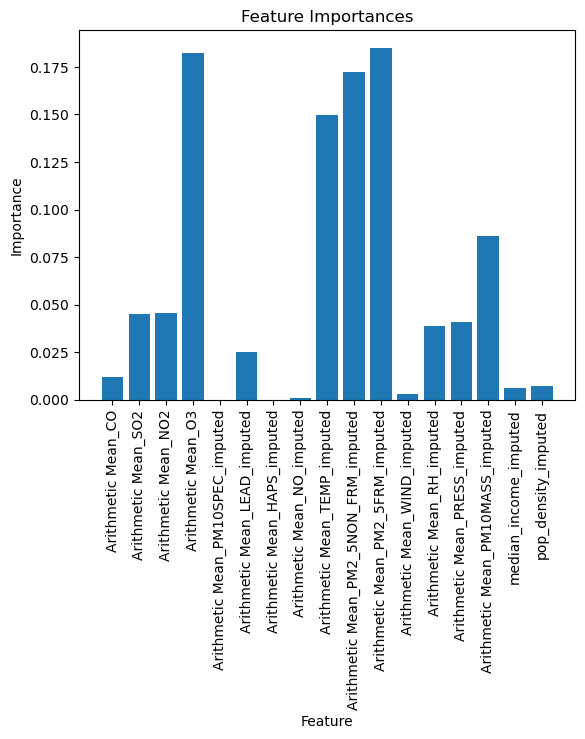

In [17]:
# Create feature importance graph 
bestModel_rf2 = bestPipeline_rf2.stages[2]
# Extract importances
importances_rf2 = bestModel_rf2.featureImportances

# Create list of importances to pass to function 
x_values_rf2 = list(range(len(importances_rf2)))

# Create bar plot 
plt.bar(x_values_rf2, importances_rf2, orientation = 'vertical')
plt.xticks(x_values_rf2, cols_rf2, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')
plt.show()

#source https://www.silect.is/blog/random-forest-models-in-spark-ml/ 

### Model 6 Performance Evaluation 

In [18]:
# Create predictions on test data 
prediction_rf2 = rf_model2.transform(holdout) 

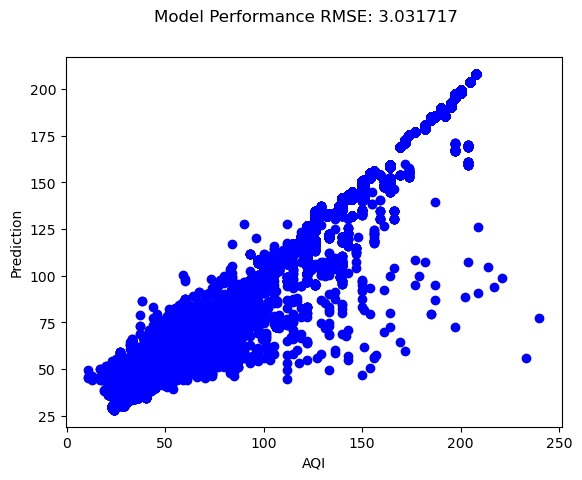

In [19]:
# Create scatterplot that shows prediction vs true value, display RMSE 

# Call evaluator on test data 
rmse_rf2 = rfEvaluator_rf2.evaluate(prediction_rf2)

# Convert to pandas df for graphing 
rfResult_rf2 = prediction_rf2.toPandas()

# Create plot
plt.plot(rfResult_rf2.AQI, rfResult_rf2.prediction, 'bo')
plt.xlabel('AQI')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse_rf2)
plt.show()

# Adapted from source: https://www.silect.is/blog/random-forest-models-in-spark-ml/

In [22]:
# Compute adjusted R^2
# First compute R^2 from model 0
summary_mod6_r2 = rfEvaluator_rf2_r2.evaluate(prediction_rf2)
n = holdout.count()
p = len(cols_rf2)

# Compute adj R^2
adjusted_mod6_r2 = 1-(1 - summary_mod6_r2)*(n-1)/(n-p-1)
print("Model 6 R^2 on holdout data = %g" % summary_mod6_r2)
#print("Model 6 Adjusted-R^2 on holdout data = %g" % adjusted_mod6_r2)

Model 6 R^2 on holdout data = 0.993534


## Research Question 3

### Predict median income at county level with gas pollutant and particulate matter data and socio-economic factor along with AQI

### Model 7

reduced set of features

#### Pipeline Formation

In [8]:
# Create list of columns to pass to VectorAssembler
cols_mod7 = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3', 'AQI', 'pop_density_imputed'] 

# Assemble predictors into feature column 
stage_1_mod7 = VectorAssembler(inputCols=cols_mod7,outputCol="features")

# Scale data for modeling 
stage_2_mod7 = StandardScaler(inputCol="features",outputCol="finalFeatures",withStd=True, withMean=True)

# Set up linear regression model 
stage_6_mod7 = LinearRegression(featuresCol="finalFeatures", labelCol='median_income_imputed')

# Create pipeline 
# Previously we had additional stages that we eventually removed which is why there is no stage 3, 4, 5
pipeline_mod7 = Pipeline(stages=[stage_1_mod7, stage_2_mod7, stage_6_mod7])

#### Grid Formation

In [9]:
# Create parameter grid to pass to cross validator
paramGrid_mod7 = ParamGridBuilder() \
    .addGrid(stage_6_mod7.fitIntercept, [True, False])\
    .addGrid(stage_6_mod7.elasticNetParam, [0, 0.5, 1]) \
    .addGrid(stage_6_mod7.regParam, [10, 0.1, 0.01]) \
    .addGrid(stage_6_mod7.maxIter, [1, 5, 10]) \
    .build()

#### Cross Validator Formation

In [10]:
# Create the evaluator that will be passed to the cross validator. 
lrevaluator_mod7 = RegressionEvaluator(labelCol="median_income_imputed", metricName="rmse")

In [11]:
# Create cross validator
crossval_mod7 = CrossValidator(estimator=pipeline_mod7,
                          estimatorParamMaps=paramGrid_mod7,
                          evaluator=lrevaluator_mod7,
                          numFolds=5, 
                          seed = 314)

#### Model 7 Training

In [12]:
# Fit model 
lrcvModel_mod7 = crossval_mod7.setParallelism(4).fit(sample)

In [13]:
# Extract the best model
mod7_best = lrcvModel_mod7.bestModel

In [14]:
# Extract parameters to view the best model
print('Best Param (regParam): ', mod7_best.stages[-1]._java_obj.getRegParam())
print('Best Param (MaxIter): ', mod7_best.stages[-1]._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', mod7_best.stages[-1]._java_obj.getElasticNetParam())

Best Param (regParam):  0.1
Best Param (MaxIter):  10
Best Param (elasticNetParam):  0.5


In [15]:
# Get metric for fit models 
lrcvModel_mod7.avgMetrics

[1782.4165220167642,
 1782.4165220167642,
 1782.4165220167642,
 1782.407358587042,
 1782.407358587042,
 1782.407358587042,
 1782.4073601303417,
 1782.4073601303417,
 1782.4073601303417,
 1879.012737834536,
 1782.9106441099148,
 1782.5122492670507,
 1878.6591919059008,
 1782.901067094685,
 1782.4070685867514,
 1878.6557838928857,
 1782.8598916037747,
 1782.4086584600254,
 1879.3679775583034,
 1783.0952418093439,
 1782.699561706975,
 1878.6629786980402,
 1782.9013965567178,
 1782.407071006751,
 1878.6561625563331,
 1782.8598637342302,
 1782.4086614073901,
 29623.559491647546,
 29623.559491647546,
 29623.559491647546,
 29623.55890851315,
 29623.55890851315,
 29623.55890851315,
 29623.558908303028,
 29623.558908303028,
 29623.558908303028,
 29629.52804122708,
 29623.589780445334,
 29623.565360760665,
 29629.505552108705,
 29623.58864033114,
 29623.557339510677,
 29629.50533603676,
 29623.586725731613,
 29623.558755715363,
 29629.55056675943,
 29623.60089353121,
 29623.57639263726,
 29629.5

### Model 7 Performance Evaluation 

In [16]:
# Predict with test data 
prediction_model7 = lrcvModel_mod7.transform(holdout) 

In [17]:
# Fit model on holdout data
mod7_lr_preds = mod7_best.transform(holdout)

# Select columns 'prediction','AQI','features' to view
mod7_lr_preds.select("prediction","median_income_imputed","features").show(5)

# Use RegressionEvaluator to compute RMSE on holdout data
lr_evaluator_7_1 = RegressionEvaluator(predictionCol="prediction", labelCol="median_income_imputed",metricName="rmse")
# Use RegressionEvaluator to compute R^2 on holdout data
lr_evaluator_7_2 = RegressionEvaluator(predictionCol="prediction", labelCol="median_income_imputed",metricName="r2")

# Print values
print("Model 7 RMSE on holdout data = %g" % lr_evaluator_7_1.evaluate(mod7_lr_preds))
print("Model 7 R^2 on holdout data = %g" % lr_evaluator_7_2.evaluate(mod7_lr_preds))

+------------------+---------------------+--------------------+
|        prediction|median_income_imputed|            features|
+------------------+---------------------+--------------------+
|30208.331313188486|              32158.0|[0.2,0.8625,4.775...|
|29150.853007492467|              25238.0|[0.238889,0.13043...|
|29867.534745233123|              29985.0|[0.331579,0.3,16....|
|29867.534745233123|              29985.0|[0.331579,0.3,16....|
|29867.534745233123|              29985.0|[0.331579,0.3,16....|
+------------------+---------------------+--------------------+
only showing top 5 rows

Model 7 RMSE on holdout data = 1787.26
Model 7 R^2 on holdout data = 0.122477


In [18]:
# Compute adjusted R^2
# First compute R^2 
summary_mod7_r2 = lr_evaluator_7_2.evaluate(mod7_lr_preds)
n = holdout.count()
p = len(cols_mod7)

# Compute adj r^2
adjusted_mod7_r2 = 1-(1 - summary_mod7_r2)*(n-1)/(n-p-1)
print("Model 7 Adjusted-R^2 on holdout data = %g" % adjusted_mod7_r2)

Model 7 Adjusted-R^2 on holdout data = 0.122467


### Model 8
Full set of features

#### Pipeline Formation

In [10]:
# Create list of columns to pass to VectorAssembler
cols_mod8 = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3','Arithmetic Mean_PM10SPEC_imputed','Arithmetic Mean_LEAD_imputed',\
        'Arithmetic Mean_HAPS_imputed','Arithmetic Mean_NO_imputed','Arithmetic Mean_TEMP_imputed','Arithmetic Mean_PM2_5NON_FRM_imputed',\
        'Arithmetic Mean_PM2_5FRM_imputed', 'Arithmetic Mean_WIND_imputed','Arithmetic Mean_RH_imputed','Arithmetic Mean_PRESS_imputed',\
        'Arithmetic Mean_PM10MASS_imputed', 'AQI', 'pop_density_imputed']

# Assemble predictors into feature column 
stage_1_mod8 = VectorAssembler(inputCols=cols_mod8,outputCol="features")

# Scale data for modeling 
stage_2_mod8 = StandardScaler(inputCol="features",outputCol="finalFeatures",withStd=True, withMean=True)
 
# Set up linear regression model
stage_6_mod8 = LinearRegression(featuresCol="finalFeatures", labelCol='median_income_imputed')

# Create pipeline 
# Previously we had additional stages that we eventually removed which is why there is no stage 3, 4, 5
pipeline_mod8 = Pipeline(stages=[stage_1_mod8, stage_2_mod8, stage_6_mod8])

#### Grid Formation

In [11]:
# Create parameter grid to pass to cross validator
paramGrid_mod8 = ParamGridBuilder() \
                    .addGrid(stage_6_mod8.fitIntercept, [True, False])\
                    .addGrid(stage_6_mod8.elasticNetParam, [0, 0.5, 1]) \
                    .addGrid(stage_6_mod8.regParam, [10, 0.1, 0.01]) \
                    .addGrid(stage_6_mod8.maxIter, [1, 5, 10]) \
                    .build()

### Cross Validator Formation

In [12]:
# Create the evaluator that will be passed to the cross validator. 
lrevaluator_mod8 = RegressionEvaluator(labelCol="median_income_imputed", metricName="rmse")

In [13]:
# Create cross validator
crossval_mod8 = CrossValidator(estimator=pipeline_mod8,
                          estimatorParamMaps=paramGrid_mod8,
                          evaluator=lrevaluator_mod8,
                          numFolds=5, 
                          seed = 314)

### Model 8 Training

In [14]:
# Fit model 
lrcvModel_mod8 = crossval_mod8.setParallelism(4).fit(sample)

In [15]:
# Extract the best model
mod8_best = lrcvModel_mod8.bestModel

In [16]:
# Extract parameters to view the best model
print('Best Param (regParam): ', mod8_best.stages[-1]._java_obj.getRegParam())
print('Best Param (MaxIter): ', mod8_best.stages[-1]._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', mod8_best.stages[-1]._java_obj.getElasticNetParam())

Best Param (regParam):  0.1
Best Param (MaxIter):  1
Best Param (elasticNetParam):  0.0


In [17]:
# Get model metrics for models fit 
lrcvModel_mod8.avgMetrics

[1655.0802348233453,
 1655.0802348233453,
 1655.0802348233453,
 1654.9607369910836,
 1654.9607369910836,
 1654.9607369910836,
 1654.9607497483962,
 1654.9607497483962,
 1654.9607497483962,
 1856.1247284041274,
 1685.810224880625,
 1659.8742559432044,
 1855.5585897021729,
 1692.574963495299,
 1658.2639464870558,
 1855.5534628105531,
 1692.126338675288,
 1657.2557526520682,
 1856.697943149721,
 1683.73625073444,
 1658.9169691133272,
 1855.5642857318705,
 1691.141545482476,
 1658.2134540346894,
 1855.5540324523604,
 1693.9169770149308,
 1658.02621504343,
 29616.183317481846,
 29616.183317481846,
 29616.183317481846,
 29616.17689667319,
 29616.17689667319,
 29616.17689667319,
 29616.176899804745,
 29616.176899804745,
 29616.176899804745,
 29628.087361156875,
 29617.9525363244,
 29616.507546017216,
 29628.05192374881,
 29618.295296196884,
 29616.350595741023,
 29628.051602733594,
 29618.27604902951,
 29616.30733162357,
 29628.123192787636,
 29617.796448543013,
 29616.404677625105,
 29628.05

## Model 8 Performance Evaluation

In [18]:
# Predict on test data 
prediction_model8 = lrcvModel_mod8.transform(holdout) 

In [19]:
# Fit model on holdout data
mod8_lr_preds = mod8_best.transform(holdout)

# Select columns 'prediction','AQI','features' to view
mod8_lr_preds.select("prediction","median_income_imputed","features").show(5)

# Use RegressionEvaluator to compute RMSE on holdout data
lr_evaluator_8_1 = RegressionEvaluator(predictionCol="prediction", labelCol="median_income_imputed",metricName="rmse")
# Use RegressionEvaluator to compute R^2 on holdout data
lr_evaluator_8_2 = RegressionEvaluator(predictionCol="prediction", labelCol="median_income_imputed",metricName="r2")

# Print values
print("Model 8 RMSE on holdout data = %g" % lr_evaluator_8_1.evaluate(mod8_lr_preds))
print("Model 8 R^2 on holdout data = %g" % lr_evaluator_8_2.evaluate(mod8_lr_preds))

+------------------+---------------------+--------------------+
|        prediction|median_income_imputed|            features|
+------------------+---------------------+--------------------+
|31823.042440182428|              32158.0|[0.2,0.8625,4.775...|
|30334.318413708057|              25238.0|[0.238889,0.13043...|
| 30085.78632337215|              29985.0|[0.331579,0.3,16....|
|30019.950560675494|              29985.0|[0.331579,0.3,16....|
|30063.113060115465|              29985.0|[0.331579,0.3,16....|
+------------------+---------------------+--------------------+
only showing top 5 rows

Model 8 RMSE on holdout data = 1653.43
Model 8 R^2 on holdout data = 0.249728


In [20]:
# Compute adjusted R^2
# First compute R^2 
summary_mod8_r2 = lr_evaluator_8_2.evaluate(mod8_lr_preds)
n = holdout.count()
p = len(cols_mod8)

# Compute adj r^2
adjusted_mod8_r2 = 1-(1 - summary_mod8_r2)*(n-1)/(n-p-1)
print("Model 8 Adjusted-R^2 on holdout data = %g" % adjusted_mod8_r2)

Model 8 Adjusted-R^2 on holdout data = 0.249704


## Model 9 Gradient Boosted Tree Classifier

In [8]:
from pyspark.ml.classification import GBTClassifier

In [9]:
# Select feature columns to include in binary logistic model
cols_gbt = ['Arithmetic Mean_CO','Arithmetic Mean_SO2','Arithmetic Mean_NO2','Arithmetic Mean_O3','Arithmetic Mean_PM10SPEC_imputed',\
            'Arithmetic Mean_LEAD_imputed','Arithmetic Mean_HAPS_imputed','Arithmetic Mean_NO_imputed','Arithmetic Mean_TEMP_imputed',\
            'Arithmetic Mean_PM2_5NON_FRM_imputed','Arithmetic Mean_PM2_5FRM_imputed', 'Arithmetic Mean_WIND_imputed','Arithmetic Mean_RH_imputed',\
            'Arithmetic Mean_PRESS_imputed','Arithmetic Mean_PM10MASS_imputed']  #still not including socio-economic data

# Use VectorAssembler to create the features column
stage_1_gbt = VectorAssembler(inputCols=cols_gbt, outputCol="features")
# Use StandardScaler to scale each feature
stage_2_gbt = StandardScaler(inputCol="features", outputCol="finalFeatures",withStd=True, withMean=True)

# Set-up logistic regression with 'class' as target variable and finalFeatures
stage_3_gbt = GBTClassifier(labelCol="class", featuresCol="finalFeatures", maxIter=10)

# Set-up pipeline object to run through each stage of modeling
pipeline_gbt = Pipeline(stages=[stage_1_gbt, stage_2_gbt, stage_3_gbt])

In [14]:
# Create parameter grid to pass to cross validator

paramGrid_gbt = ParamGridBuilder()   \
                     .addGrid(stage_3_gbt.maxDepth, [5, 10, 20])   \
                     .addGrid(stage_3_gbt.maxBins, [20, 40])    \
                     .addGrid(stage_3_gbt.maxIter, [1, 5, 10])    \
                     .build()

In [15]:
# Create the evaluator that will be passed to the cross validator. 
# Set-up binary logistic regression model evaluator
gbt_Evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='class')

In [16]:
# Create cross validator
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=gbt_Evaluator,
                              numFolds=5,
                              seed = 314)

In [17]:
# Fit crossvalidator to sample data, compute in parallel
gbt_model = crossval_gbt.setParallelism(4).fit(sample) 

In [19]:
# Extract the best model
gbt_best = gbt_model.bestModel

In [20]:
# Extract parameters to view the best model
print('GBT Best Param (Max Depth): ', gbt_best.stages[-1]._java_obj.getMaxDepth())
print('GBT Best Param (Max Bins): ', gbt_best.stages[-1]._java_obj.getMaxBins())
print('GBT Best Param (Max Iter): ', gbt_best.stages[-1]._java_obj.getMaxIter())

GBT Best Param (Max Depth):  10
GBT Best Param (Max Bins):  40
GBT Best Param (Max Iter):  10


In [21]:
# predict on holdout data
preds_gbt = gbt_best.transform(holdout)

In [22]:
# predictions on holdout data
# Create both evaluators
predsRDD_gbt = preds_gbt.select(['class', 'prediction']).rdd.map(lambda line: (line[1], line[0]))

metrics_binary_gbt = BinaryClassificationMetrics(predsRDD_gbt)
metrics_multi_gbt = MulticlassMetrics(predsRDD_gbt)

acc = metrics_multi_gbt.accuracy
f1 = metrics_multi_gbt.fMeasure(1.0)
precision = metrics_multi_gbt.precision(1.0)
recall = metrics_multi_gbt.recall(1.0)
auc = metrics_binary_gbt.areaUnderROC
au_pr = metrics_binary_gbt.areaUnderPR


In [23]:
# Confusion Matrix
print(metrics_multi_gbt.confusionMatrix().toArray())

# Overall statistics
print("Model 9 GBT Accuracy on holdout data = %g" % acc)
print("Model 9 GBT Precision on holdout data = %g" %precision)
print("Model 9 GBT F1 on holdout data = %g" % f1)
print("Model 9 GBT Recall on holdout data = %g" % recall)
print("Model 9 GBT AUROC on holdout data = %g" % auc)
print("Model 9 GBT AUPR Curve on holdout data = %g" % au_pr)

[[3.78632e+05 1.15000e+02]
 [2.76000e+02 1.50918e+05]]
Model 9 GBT Accuracy on holdout data = 0.999262
Model 9 GBT Precision on holdout data = 0.999239
Model 9 GBT F1 on holdout data = 0.998706
Model 9 GBT Recall on holdout data = 0.998175
Model 9 GBT AUROC on holdout data = 0.998935
Model 9 GBT AUPR Curve on holdout data = 0.998587


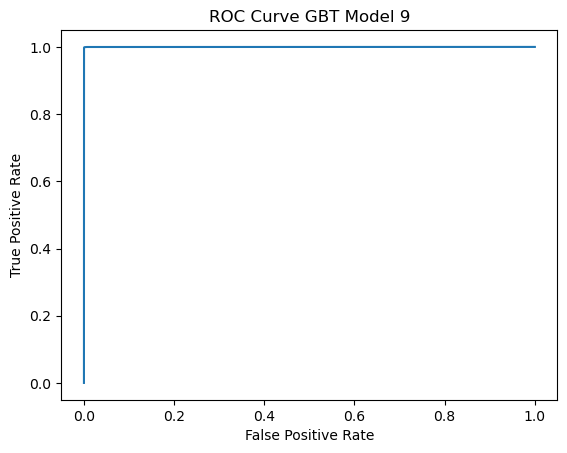

In [24]:
# Create ROC curve 
# Define ROC curve function 
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        roc = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            roc += [(float(row._1()), float(row._2()))]
        return roc

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
# Source: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

# Returns as a list (false positive rate, true positive rate)
predsROC = preds_gbt.select('class','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['class'])))
roc = CurveMetrics(predsROC).get_curve('roc')

plt.figure()
x_val = [x[0] for x in roc]
y_val = [x[1] for x in roc]
plt.title('ROC Curve GBT Model 9')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)
plt.show()